# Feature Selection

This user guide details how DNAMite can be used for feature selection / feature-sparse prediction.

### Why Bother with Feature Selection?

When training a black-box machine learning model, it is common practice to use all available features even for high-dimensional datasets, as modern ML models can easily handle many features. However, there are some settings where feature selection is very useful:

1) **Interpretability**: When training a glass-box model, we need to care about both predictive performance as well as accurate and utility of explanations. While glass-box models often have good accurate on high-dimensional datasets, model explanations are much more likely to be impaired in such settings. In particular, when sets of correlated features are all used in the same dataset, additive models like DNAMite run into identifiability issues with how to spread contribution across the feature set. This tends to cause increased variance in feature importances and shape functions, reducing confidence in the model's interpretations.

2) **Simplicity**: Models that use less features are inherently simpler models, which can help with both interpretability and generalizability. For example, consider a model used to predict cancer risk which uses hundreds of features. This model is harder to explain completely doctors and patients since even a glass-box model like DNAMite requires hundreds of shape function plots to describe completely. Also, if the model is deployed to a different medical network than is used during training, it's likely that several features are not available at the new medical network which increases missing values and thus decreases predictive performance.

3) **Extreme High-Dimensionality**: In datasets that are extremely high-dimensional (e.g. more features than samples), feature selection can be beneficial even just for improving predictive accuracy along with the above reasons. One common example is genomic datasets where samples are expensive to collect but each sample can many thousands of features on the expression level of various genes. 

### DNAMite Example

To showcase the capabilities of DNAMite for feature selection, we'll consider a mortality prediction binary classification problem. We gather data from the [MIMIC III dataset](https://physionet.org/content/mimiciii/1.4/), an open-source collection of electronic health records from the Beth Israel Deaconess Medical Center in Boston, Massachusetts. We follow the [MIMIC III benchmark](https://github.com/YerevaNN/mimic3-benchmarks) to generate preprocessed mortality prediction data from the raw MIMIC III files. Specifically, we use the preprocessing used for the logistic regression benchmark which generates many tabular features from each of a set of time-dependent features. This presents a great use case for feature selection, as the initial dataset has many features which are likely to be redundant.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_theme()
from sklearn.model_selection import train_test_split
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

df_train = pd.read_csv("mortality_tab_train.csv")
X_train = df_train.drop(["target"], axis=1)
y_train = df_train["target"]

df_test = pd.read_csv("mortality_tab_test.csv")
X_test = df_test.drop(["target"], axis=1)
y_test = df_test["target"]

In [5]:
# Check the initial dataset size
print("Train data size", X_train.shape)

# Check how many features come from each base feature
pd.Series([c.split("|")[0] for c in X_train.columns]).value_counts()

Train data size (14680, 714)


Capillary refill rate                  42
Height                                 42
Weight                                 42
Temperature                            42
Systolic blood pressure                42
Respiratory rate                       42
Oxygen saturation                      42
Mean blood pressure                    42
Heart Rate                             42
Diastolic blood pressure               42
Glucose                                42
Glascow coma scale verbal response     42
Glascow coma scale total               42
Glascow coma scale motor response      42
Glascow coma scale eye opening         42
Fraction inspired oxygen               42
pH                                     42
Name: count, dtype: int64

Our training data has 714 features, and further inspection shows us that there are only 17 base features, each of which has 42 derived features. 

First, let's see what happens if we fit a DNAMite model to the full training data without any feature selection.

In [6]:
from dnamite.models import DNAMiteBinaryClassifier

model = DNAMiteBinaryClassifier(n_features=X_train.shape[1], device=device)
model.fit(X_train, y_train)

Discretizing features...


100%|██████████| 714/714 [00:00<00:00, 1089.09it/s]


SPlIT 0
TRAINING MAINS


Early stopping at 6 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 1
TRAINING MAINS


Early stopping at 7 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 2
TRAINING MAINS


Early stopping at 7 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 3
TRAINING MAINS


Early stopping at 6 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 4
TRAINING MAINS


Early stopping at 6 epochs: Test loss has not improved for 5 consecutive epochs.


In [7]:
from sklearn.metrics import roc_auc_score
print("TEST AUC: ", roc_auc_score(y_test, model.predict_proba(X_test)))

TEST AUC:  0.8475664899083323


The model has reasonably good test AUC. Now let's look at the model's importances and shape functions.

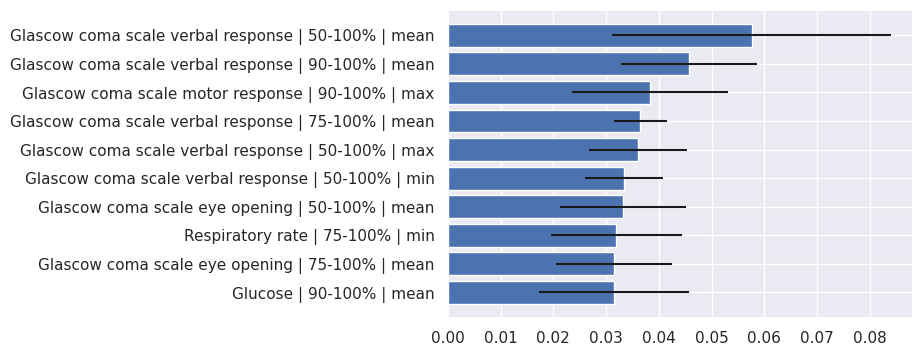

In [8]:
model.plot_feature_importances()

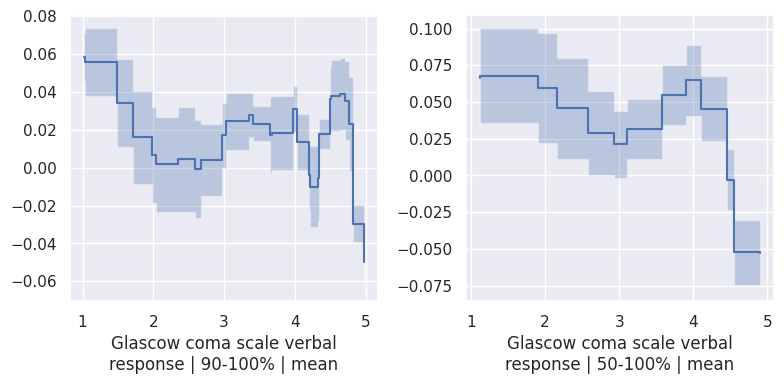

In [9]:
model.plot_shape_function(
    ["Glascow coma scale verbal response | 90-100% | mean", "Glascow coma scale verbal response | 50-100% | mean"]
)

First, both the feature importance scores and the shape functions of the top 2 features are quite noisy. Second, there is a lot of redundancy. The base feature "Glascow coma scale verbal response" is the base feature for each of the top 6 features by importance, and the shape functions for the first two of these features have similar shapes (albeit with significant noise).

Now, let's see how the model changes if we do feature selection. We start by using the `select_features(...)` function to select a set of features from the full dataset. We introduce two new parameters to DNAMite to allow for feature selection: `reg_param` which controls how strong feature selection we desire, and `gamma` which controls how fast feature are pruned.

In [29]:
model_sparse = DNAMiteBinaryClassifier(
    n_features=X_train.shape[1], 
    device=device, 
)
model_sparse.select_features(
    X_train, 
    y_train, 
    reg_param=0.004,
    gamma=0.05
)

Discretizing features...


100%|██████████| 714/714 [00:00<00:00, 1225.39it/s]


Epoch 1 | Train loss: 1.348 | Test loss: 0.808 | Active features: 663


Epoch 2 | Train loss: 0.570 | Test loss: 0.419 | Active features: 556


Epoch 3 | Train loss: 0.369 | Test loss: 0.345 | Active features: 458


Epoch 4 | Train loss: 0.334 | Test loss: 0.334 | Active features: 339


Epoch 5 | Train loss: 0.325 | Test loss: 0.330 | Active features: 237


Epoch 6 | Train loss: 0.322 | Test loss: 0.329 | Active features: 129


Epoch 7 | Train loss: 0.319 | Test loss: 0.329 | Active features: 68


Epoch 8 | Train loss: 0.319 | Test loss: 0.327 | Active features: 46


Epoch 9 | Train loss: 0.317 | Test loss: 0.324 | Active features: 31


Epoch 10 | Train loss: 0.315 | Test loss: 0.330 | Active features: 29


Epoch 11 | Train loss: 0.315 | Test loss: 0.330 | Active features: 25


Epoch 12 | Train loss: 0.314 | Test loss: 0.330 | Active features: 24


Epoch 13 | Train loss: 0.313 | Test loss: 0.328 | Active features: 25


Epoch 14 | Train loss: 0.311 | Test loss: 0.331 | Active features: 24
Early stopping at 14 epochs: Test loss has not improved for 5 consecutive epochs.
Number of main features selected:  24


We see that DNAMite has selected 24 features from the original set of 714 features. The selected features can be accessed in the `selected_feats` attribute.

In [30]:
model_sparse.selected_feats

['Diastolic blood pressure | 0-50% | mean',
 'Glascow coma scale eye opening | 75-100% | mean',
 'Glascow coma scale motor response | full | max',
 'Glascow coma scale motor response | 90-100% | max',
 'Glascow coma scale motor response | 90-100% | mean',
 'Glascow coma scale total | 50-100% | max',
 'Glascow coma scale verbal response | 75-100% | mean',
 'Glascow coma scale verbal response | 90-100% | mean',
 'Glucose | 0-10% | skew',
 'Glucose | 90-100% | mean',
 'Mean blood pressure | full | min',
 'Mean blood pressure | full | mean',
 'Oxygen saturation | 90-100% | min',
 'Respiratory rate | full | mean',
 'Respiratory rate | 0-10% | min',
 'Respiratory rate | 0-10% | mean',
 'Respiratory rate | 0-50% | mean',
 'Systolic blood pressure | full | mean',
 'Temperature | full | mean',
 'Temperature | 0-10% | skew',
 'Temperature | 0-25% | len',
 'Temperature | 75-100% | min',
 'Temperature | 75-100% | mean',
 'pH | 0-50% | len']

After selecting features, we can fit a DNAMite model to the selected features by running `fit(...)`, passing in the entire training data. 

In [31]:
model_sparse.fit(X_train, y_train)

SPlIT 0
Found selected features. Using only those features.
TRAINING MAINS


Early stopping at 15 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 1
Found selected features. Using only those features.
TRAINING MAINS


Early stopping at 10 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 2
Found selected features. Using only those features.
TRAINING MAINS


Early stopping at 9 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 3
Found selected features. Using only those features.
TRAINING MAINS


Early stopping at 15 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 4
Found selected features. Using only those features.
TRAINING MAINS


Early stopping at 10 epochs: Test loss has not improved for 5 consecutive epochs.


In [32]:
print("TEST AUC: ", roc_auc_score(y_test, model_sparse.predict_proba(X_test)))

Found selected features. Using only those features.


TEST AUC:  0.8168505252301035


This sparse DNAMite model has an AUC of around 0.82, compared to the original model which had an AUC of around 0.84. Thus, we have slightly reduced the predictive performance when going from 714 to 24 features. Let's now look at the interpretations to see how they are affected by feature selection. 

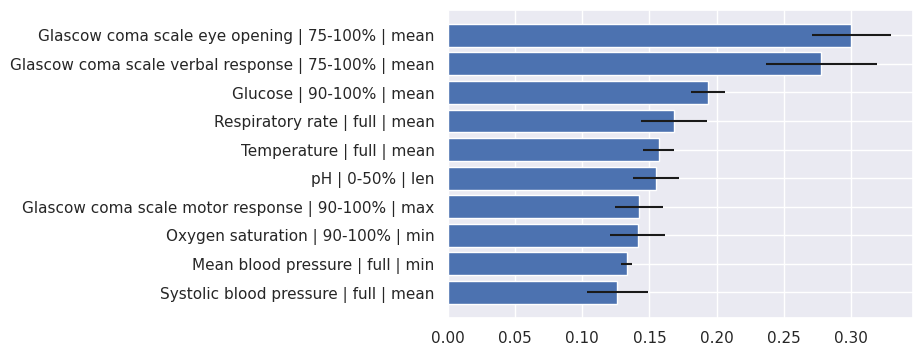

In [33]:
model_sparse.plot_feature_importances()

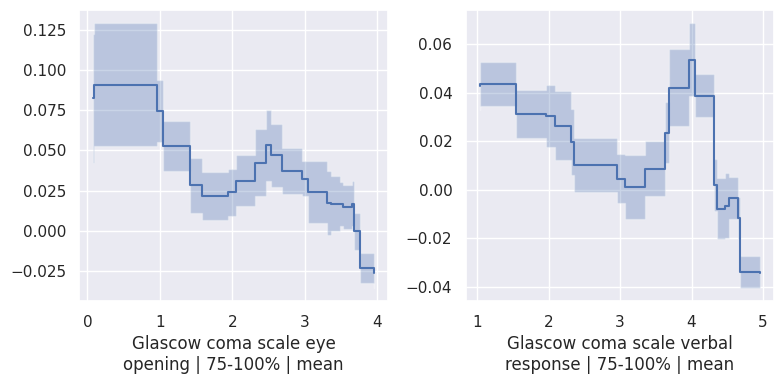

In [35]:
model.plot_shape_function(
    ["Glascow coma scale eye opening | 75-100% | mean", "Glascow coma scale verbal response | 75-100% | mean"]
)

Compared to the model that uses all features, this feature sparsity DNAMite model has much less noise in the feature importances and shape functions. The top 6 features all come from different base features, illustrating that this model has less problems with feature correlation compared to the first model.

### Implementation Details

DNAMite does feature selection using the differential binary gates method first introduced in [1]. When doing feature selection, DNAMite fits an additive model of the form (ignoring interactions for simplicity) $$ f(X) = \sum_j f_j(X_j) s(\mu_j) $$ where $s(\mu_j)$ is the *smooth-step function* with learnable parameter $\mu_j$: 
$$ 
s(\mu; \gamma)
\begin{cases}
    0 & \text{if } \mu \leq -\gamma/2 \\
    -\frac{2}{\gamma^3}\mu^3 + \frac{3}{2\gamma}\mu + \frac{1}{2} & \text{if } -\gamma/2 \leq \mu \leq \gamma/2 \\
    1 & \text{if } \mu \geq \gamma/2
\end{cases}.
$$
During training, if $\mu_j$ is updated such that $s(\mu_j) = 0$, then feature $j$ no longer impact the model and thus can be pruned.

In order to encourage sparsity during training, DNAMite uses two additional loss regularizers. First, a sparsity regularizer encourages the $s(\mu_j)$'s to be small: $$L_S = \lambda \sum_j s(\mu_j).$$ Second, an entropy regularizer encourages the $s(\mu_j)$'s to converge to either 0 or 1: 
\begin{align*}
L_E &= \tau \left( \sum_j \Omega(s(\mu_j)) + \sum_{j,l} \Omega(s(\mu_{j,l})) \right) \\
\Omega(x) &= -\left( x \log(x) + (1-x) \log(1-x) \right)
\end{align*}

For further details on how DNAMite does feature selection, see [2].

[1] Ibrahim, Shibal, et al. "GRAND-SLAMIN’Interpretable Additive Modeling with Structural Constraints." Advances in Neural Information Processing Systems 36 (2024).

[2] Van Ness, Mike, and Madeleine Udell. "Interpretable Prediction and Feature Selection for Survival Analysis." arXiv preprint arXiv:2404.14689 (2024).

### Hyperparameters


DNAMite has multiple hyperparameters that can be set to control feature selection. Below each of these parameters is fully described.

- `reg_param`: this it the main hyperparameter that controls the strength of feature selection. It is equivalent to $\lambda$ in the sparsity regularizer $L_S$ above. 
- `pair_reg_param`: this is similar to `reg_param` except it controls the strength of feature selection for interactions opposed to main features. Since interactions are chosen and pruned after main feature selection, this parameter often can be set to a smaller value than `reg_param`. 
- `gamma`: this hyperparameter controls how quickly the smooth-step functions $s(\mu_j)$ reach 0 and 1. A smaller value of `gamma` will result in features being pruned earlier in training, while a larger value will cause features to be pruned later in training. The default value is `gamma = 1`, but in our experience a smaller value is often needed for smaller datasets.
- `entropy_param`: this hyperparameter is equivalent to $\tau$ in the entropy regularizer $L_E$ above. Similar to `gamma`, different values of `entropy_param` impact how quickly features are pruned during training. Higher values of `entropy_param` will cause features/interactions to be pruned faster. The default of `entropy_param = 0.001` is usually a good starting point.